# MATMUL benchmark
    
Doba výpočtu bodového algoritmu:

$$
  T \approx 2 n^3 T_{RAM}.
$$

Doba výpočtu blokového algoritmu ($b$ - velikost bloku)
$$
    T \approx \left(3 b^2 T_{RAM} + 2 b^3 T_{Cache}\right) \left(\frac{n}{b}\right)^3 = n^3 \left( \frac{3T_{RAM}}{b} + 2 T_{Cache}\right).
$$

In [1]:
function testmatrix(n)
    A = zeros(n,n)
    for i=1:n, j=1:n
        A[i,j] = i - j
    end
    return A
end;

In [2]:
function matmul_kji!(C, A, B)
    @assert size(A,2) == size(B,1) 
    @assert size(A,1) == size(C,1) && size(B,2) == size(C,2) 
 
    for i=1:size(C,1), j=1:size(C,2)
       @inbounds C[i,j] = zero(C[1,1])
    end
    
    for k=1:size(A,2)
        for j=1:size(B,2)
            for i=1:size(A,1)
               @inbounds C[i,j] += A[i,k] * B[k,j]
            end
        end
    end
end;

In [3]:
function matmul_ijk!(C, A, B)
    @assert size(A,2) == size(B,1) 
    @assert size(A,1) == size(C,1) && size(B,2) == size(C,2) 

    for i=1:size(C,1), j=1:size(C,2)
        @inbounds C[i,j] = zero(C[1,1])
    end
    
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                @inbounds C[i,j] += A[i,k] * B[k,j]
            end
        end
    end
end;

In [4]:
function matmul_jki!(C, A, B)
    @assert size(A,2) == size(B,1) 
    @assert size(A,1) == size(C,1) && size(B,2) == size(C,2) 

    for i=1:size(C,1), j=1:size(C,2)
        @inbounds C[i,j] = zero(C[1,1])
    end
    
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                @inbounds C[i,j] += A[i,k] * B[k,j]
            end
        end
    end
end;

In [5]:
function matmul_block!(C, A, B)
    @assert size(A,2) == size(B,1) 
    @assert size(A,1) == size(C,1) && size(B,2) == size(C,2) 

    
    function pointwise_matmul(i1, i2, j1, j2, k1, k2)
        for j=j1:j2
            for k=k1:k2
                for i=i1:i2
                    @inbounds C[i,j] += A[i,k] * B[k,j]
                end
            end
        end
    end

    for i=1:size(C,1), j=1:size(C,2)
        C[i,j] = zero(C[1,1])
    end

    block = 100

    for i=1:size(C,1), j=1:size(C,2)
        @inbounds C[i,j] = zero(C[1,1])
    end
    

    for k=1:block:size(A,2)
        kend = min(k+block-1, size(A,2))

        for j=1:block:size(B,2)
            jend = min(j+block-1, size(B,2))

            for i=1:block:size(A,1)
                iend = min(i+block-1, size(A,1))

                pointwise_matmul(i,iend, j,jend, k,kend)

            end
        end
    end
end;

In [6]:
function matmul_openblas!(C, A, B)
    CblasColMajor = 102
    CblasNoTrans = 111
    ccall( (:cblas_dgemm, "libopenblas"),

    Cvoid, 
    (Clonglong, Clonglong, Clonglong, Clonglong, Clonglong, Clonglong, 
    Cdouble, Ptr{Cdouble}, Clonglong, 
    Ptr{Cdouble}, Clonglong, 
    Cdouble, Ptr{Cdouble}, Clonglong),

    CblasColMajor, CblasNoTrans, CblasNoTrans,
    size(A,1), size(A,2), size(B,2),
    1.0, A, size(A,1),
    B, size(B,1),
    0.0, C, size(C,1)
    )
    end;

In [7]:
function A_mul_B!(C,A,B)
    C = A*B
end

A_mul_B! (generic function with 1 method)

In [8]:
A10 = testmatrix(10);
B10 = copy(A10);
C10 = copy(A10);

@time matmul_ijk!(C10, A10, B10);
@time matmul_jki!(C10, A10, B10);
@time matmul_kji!(C10, A10, B10);
@time matmul_block!(C10, A10, B10);
@time A_mul_B!(C10, A10, B10);
@time matmul_openblas!(C10, A10, B10)

  0.039590 seconds (41.15 k allocations: 1.998 MiB)
  0.048284 seconds (41.13 k allocations: 1.997 MiB)
  0.054749 seconds (41.13 k allocations: 1.997 MiB)
  0.088903 seconds (77.83 k allocations: 3.744 MiB)
  0.643214 seconds (882.95 k allocations: 42.004 MiB, 2.41% gc time)
  0.010091 seconds (15.95 k allocations: 893.561 KiB)


In [9]:
A10 = testmatrix(1000);
B10 = copy(A10);
C10 = copy(A10);

@time matmul_ijk!(C10, A10, B10);
@time matmul_jki!(C10, A10, B10);
@time matmul_kji!(C10, A10, B10);
@time matmul_block!(C10, A10, B10);
@time A_mul_B!(C10, A10, B10);
@time matmul_openblas!(C10, A10, B10)

  1.619998 seconds (4 allocations: 160 bytes)
  0.531984 seconds (4 allocations: 160 bytes)
  1.201830 seconds (4 allocations: 160 bytes)
  0.315461 seconds (5 allocations: 192 bytes)
  0.053177 seconds (6 allocations: 7.630 MiB)
  0.035093 seconds (4 allocations: 160 bytes)


In [10]:
function bench(fun)
    n = [10, 50, 100, 200, 500, 1000, 1500, 2000, 2500]
    t  = zeros(Float64, size(n))

    for i=1:size(n,1)
        A = testmatrix(n[i])
        B = copy(A)
        C = copy(A)

        t1 = time_ns()
        fun(A, B, C)
        t[i] = (time_ns() - t1) * 1.e-9
    end
    return t, n
end;

In [11]:
t_ijk, n = bench(matmul_ijk!);

In [12]:
t_jki, n = bench(matmul_jki!);

In [13]:
t_kji, n = bench(matmul_kji!);

In [14]:
t_block, n = bench(matmul_block!);

In [15]:
t_builtin, n = bench(A_mul_B!);

In [16]:
t_openblas, n = bench(matmul_openblas!);

In [17]:
mflops(t, n) = [ 1.e-6 * 2 * float(n[i])^3 / t[i] for i in 1:size(t,1)]

mflops (generic function with 1 method)

In [18]:
using PyPlot;

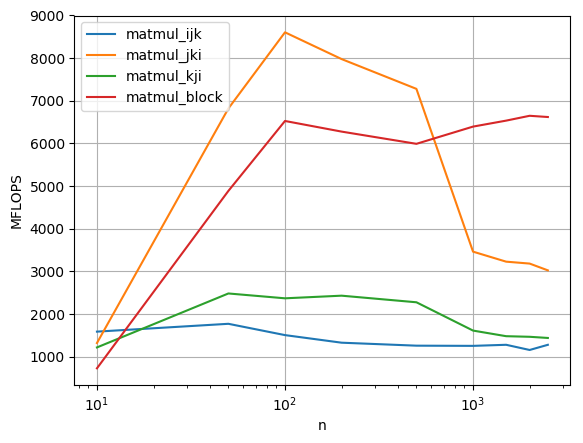

In [19]:
semilogx(n, mflops(t_ijk,n), label="matmul_ijk");
semilogx(n, mflops(t_jki,n), label="matmul_jki");
semilogx(n, mflops(t_kji,n), label="matmul_kji");
semilogx(n, mflops(t_block,n), label="matmul_block");
#semilogx(n, mflops(t_builtin,n), label="matmul_builtin");
#semilogx(n, mflops(t_openblas,n), label="matmul_openblas");
legend(loc="upper left"); xlabel("n"); ylabel("MFLOPS");
grid(true);


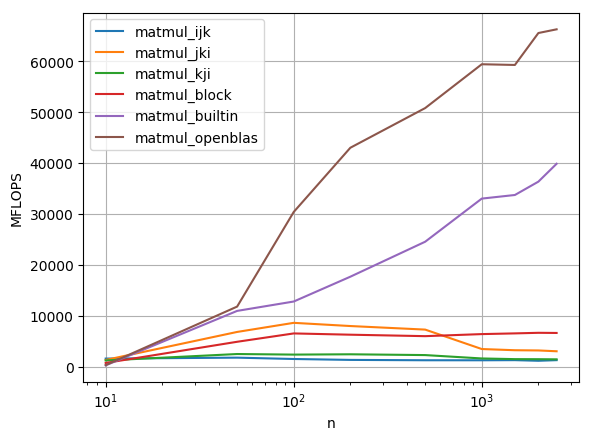

In [20]:
semilogx(n, mflops(t_ijk,n), label="matmul_ijk");
semilogx(n, mflops(t_jki,n), label="matmul_jki");
semilogx(n, mflops(t_kji,n), label="matmul_kji");
semilogx(n, mflops(t_block,n), label="matmul_block");
semilogx(n, mflops(t_builtin,n), label="matmul_builtin");
semilogx(n, mflops(t_openblas,n), label="matmul_openblas");
legend(loc="upper left"); xlabel("n"); ylabel("MFLOPS");
grid(true);


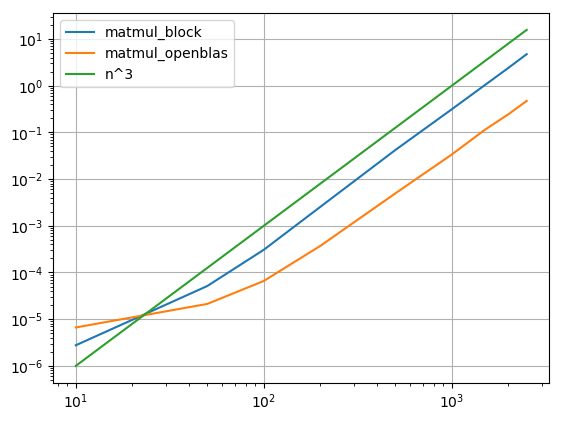

In [21]:
loglog(n,t_block, label="matmul_block")
loglog(n,t_openblas, label="matmul_openblas")
loglog(n,1e-9*n .^3, label="n^3")
grid(true)
legend(loc="upper left");